In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as functions
import matplotlib.pyplot as plt
import os
if torch.cuda.is_available():
    print('device available')
    device = torch.device('cuda')
else:
    print('device unavailable')
    device = None
print(os.getcwd())

device available
/content


In [ ]:
X = np.load('drive/My Drive/Colab Notebooks/MVN_X.npy')
Y = np.load('drive/My Drive/Colab Notebooks/MVN_Y.npy')
print(Y[:10])

[0. 1. 0. 0. 0. 1. 0. 1. 0. 1.]


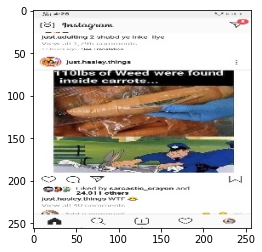

In [ ]:
plt.imshow(X[2,:,:,::-1])

In [ ]:
X_test = X[1500:1600]
Y_test = Y[1500:1600]
print(X_test.shape)
print(Y_test[:10])

(100, 256, 256, 3)
[1. 0. 1. 1. 0. 1. 1. 0. 0. 0.]


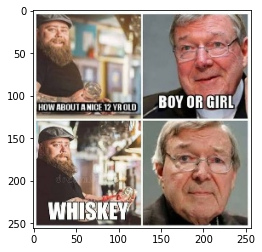

In [ ]:
plt.imshow(X_test[4,:,:,::-1])

In [ ]:
X = X[:1500]
Y = Y[:1500]
print(X.shape)
print(Y.shape)

(1500, 256, 256, 3)
(1500,)


In [ ]:
# converting all to float and normalizing
X = (X.astype(float))/255
Y = (Y.astype(float))
X_test = (X_test.astype(float))/255
Y_test = (Y_test.astype(float))
X = np.transpose(X,(0,3,1,2))
X_test = np.transpose(X_test,(0,3,1,2))
print(X_test.shape)

(100, 3, 256, 256)


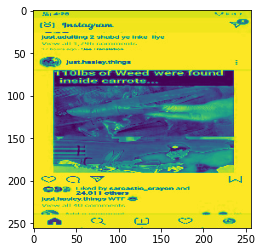

In [ ]:
plt.imshow(X[2,0,:,:])

In [ ]:
X = torch.from_numpy(X)
Y = torch.from_numpy(Y)
X = X.to(device)
Y = Y.to(device)
print(type(X))
print(type(Y))

<class 'torch.Tensor'>
<class 'torch.Tensor'>


In [ ]:
#MVN1
class MVNNet(nn.Module):
    # 7 convolutional layers
    # 4 pooling layers
    # 3 fully connected layers
    def __init__(self):
        super(MVNNet,self).__init__()
        self.conv1 = nn.Conv2d(3,60,(5,5))
        self.conv2 = nn.Conv2d(60,80,(7,7))
        self.conv3 = nn.Conv2d(80,102,(5,5))
        self.conv4 = nn.Conv2d(102,130,(5,5))
        self.conv5 = nn.Conv2d(130,180,(5,5))
        self.conv6 = nn.Conv2d(180,206,(5,5))
        self.conv7 = nn.Conv2d(206,230,(5,5))
        self.fc1 = nn.Linear(230*7*7,7568)
        self.fc2 = nn.Linear(7568,2551)
        self.fc3 = nn.Linear(2551,1)


    def forward(self,x):
        x = functions.relu(self.conv1(x))
        x = functions.max_pool2d(x,(2,2))
        x = functions.relu(self.conv2(x))
        x = functions.max_pool2d(x,(2,2))
        x = functions.relu(self.conv3(x))
        x = functions.relu(self.conv4(x))
        x = functions.max_pool2d(x,(2,2))
        x = functions.relu(self.conv5(x))
        x = functions.relu(self.conv6(x))
        x = functions.relu(self.conv7(x))
        x = functions.max_pool2d(x,(2,2))
        x = x.view(x.size(0),-1)
        x = functions.relu(self.fc1(x))
        x = functions.relu(self.fc2(x))
        x = self.fc3(x)
        #x = nn.Sigmoid()(x)
        return x

In [ ]:
#MVN2
class MVNNet(nn.Module):
  def __init__(self):
    super(MVNNet,self).__init__()
    self.conv1 = nn.Conv2d(3,96,(11,11),stride=(4,4))
    self.conv2 = nn.Conv2d(96,134,(5,5),stride=(4,4))
    self.conv3 = nn.Conv2d(134,158,(3,3))
    self.fc1 = nn.Linear(158*2*2,252)
    self.fc2 = nn.Linear(252,1)

  def forward(self,x):
    x = functions.relu(self.conv1(x))
    x = functions.relu(self.conv2(x))
    x = functions.max_pool2d(x,(2,2))
    x = functions.relu(self.conv3(x))
    x = functions.max_pool2d(x,(2,2))
    x = x.view(x.size(0),-1)
    x = functions.relu(self.fc1(x))
    x = self.fc2(x)
    return x

In [ ]:
#Non Conv (MVN3)
class MVNNet(nn.Module):
  def __init__(self):
    super(MVNNet,self).__init__()
    self.fc1 = nn.Linear(256*256*3,1000)
    self.fc2 = nn.Linear(1000,50)
    self.fc3 = nn.Linear(50,1)

  def forward(self,x):
    x = x.reshape(x.size(0),-1)
    x = functions.relu(self.fc1(x))
    x = functions.relu(self.fc2(x))
    x = self.fc3(x)
    return x

In [ ]:
net = MVNNet().double()
net.to(device)
optimizer = optim.Adam(net.parameters(),lr=0.001)

In [ ]:
total_size = X.size(0)
batchsize = 15
epochs = 3
cost_fn = nn.BCEWithLogitsLoss()
costs = []
epoch_costs = []
for i in range(epochs):
    for j in range(int(total_size/batchsize)):
        #torch.cuda.empty_cache()
        optimizer.zero_grad()
        #X_minibatch = X[j*batchsize:(j+1)*batchsize]
        #Y_minibatch = Y[j*batchsize:(j+1)*batchsize]
        output = net(X[j*batchsize:(j+1)*batchsize])
        cost = cost_fn(output,Y[j*batchsize:(j+1)*batchsize].view(batchsize,1))
        cost.backward()
        optimizer.step()
        costs.append(float(cost.item()))
        if(j%10 == 0):
            print(str(cost.item())+' at epoch '+str(i))
        if(j == 0):
            epoch_costs.append(cost.item())
        del output
        del cost
        torch.cuda.empty_cache()
    print('epoch complete')

0.7001718646784499 at epoch 0
10.130894265935463 at epoch 0
3.239430255894181 at epoch 0
2.38619532916403 at epoch 0
0.2433770896729368 at epoch 0
0.6431832589992473 at epoch 0
1.4483831261303868 at epoch 0
0.6184007988227038 at epoch 0
0.4366390316779385 at epoch 0
0.18805724699418613 at epoch 0
epoch complete
0.3752831990426636 at epoch 1
0.3691459424344345 at epoch 1
0.5080335288229737 at epoch 1
0.2651753232421846 at epoch 1
0.18117849069158004 at epoch 1
0.6834877635614294 at epoch 1
3.6863249213808036 at epoch 1
1.4226533680226165 at epoch 1
0.40567891827835045 at epoch 1
0.35827764004581897 at epoch 1
epoch complete
0.20100844247772268 at epoch 2
0.5262179617216686 at epoch 2
0.5093052622925256 at epoch 2
0.12923077774784483 at epoch 2
0.6636239080566063 at epoch 2
0.33721147173753907 at epoch 2
2.0404504227870723 at epoch 2
0.5781072350383951 at epoch 2
0.6766743110694003 at epoch 2
0.25259576531079436 at epoch 2
epoch complete


300
0.0451421116957632


Text(0.5, 1.0, 'Cost per iteration')

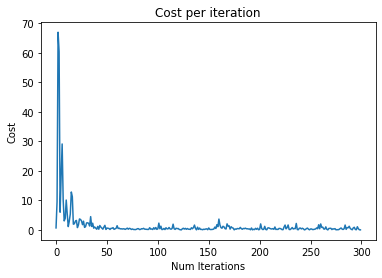

In [ ]:
print(len(costs))
print(costs[-1])
plt.plot(costs)
plt.ylabel('Cost')
plt.xlabel('Num Iterations')
plt.title('Cost per iteration')

3
[0.7001718646784499, 0.3752831990426636, 0.20100844247772268]


Text(0.5, 1.0, 'Costs per Epoch')

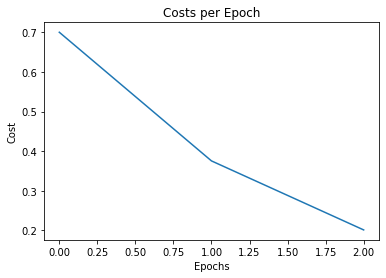

In [ ]:
print(len(epoch_costs))
print(epoch_costs)
plt.plot(epoch_costs)
plt.ylabel('Cost')
plt.xlabel('Epochs')
plt.title('Costs per Epoch')

In [ ]:
torch.save(net.state_dict(),'/content/drive/My Drive/Colab Notebooks/MVN3.pth')
net.eval()

MVNNet(
  (fc1): Linear(in_features=196608, out_features=1000, bias=True)
  (fc2): Linear(in_features=1000, out_features=50, bias=True)
  (fc3): Linear(in_features=50, out_features=1, bias=True)
)

In [ ]:
net = MVNNet().double()
net.load_state_dict(torch.load('/content/drive/My Drive/Colab Notebooks/MVN2.pth'))
net.to(device)
net.eval()

MVNNet(
  (conv1): Conv2d(3, 96, kernel_size=(11, 11), stride=(4, 4))
  (conv2): Conv2d(96, 134, kernel_size=(5, 5), stride=(4, 4))
  (conv3): Conv2d(134, 158, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=632, out_features=252, bias=True)
  (fc2): Linear(in_features=252, out_features=1, bias=True)
)

In [ ]:
torch.cuda.empty_cache()
with torch.no_grad():
    for j in range(int((1500/15))):
        train_results_temp = net(X[j*15:(j+1)*15])
        train_results_temp = nn.Sigmoid()(train_results_temp)
        train_results_temp = train_results_temp.cpu().numpy()
        train_results = train_results_temp if (j == 0) else np.concatenate((train_results,train_results_temp))
        del train_results_temp
    train_labels = Y.cpu().numpy()
print(train_results.shape)
print(train_labels.shape)

(1500, 1)
(1500,)


In [ ]:
#print(np.mean(train_results))
print(train_results.shape)
train_results = np.squeeze(train_results)
print(train_results[:10])

(1500, 1)
[5.42710701e-03 9.26041682e-01 3.03756462e-04 5.96571117e-05
 2.34171897e-03 3.88205997e-01 3.05048660e-02 4.50260598e-01
 1.51277128e-03 4.29483648e-01]


In [ ]:
print(Y[:10])

tensor([0., 1., 0., 0., 0., 1., 0., 1., 0., 1.], device='cuda:0',
       dtype=torch.float64)


In [ ]:
train_results = (train_results > 0.5).astype(float)
print(train_results[:10])
print('these are train labels')
print(train_labels[:10])
predictions = (train_results == Y.cpu().numpy()).astype(float)
accuracy = (np.sum(predictions))/(predictions.shape)
print(float(accuracy*100))

[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
these are train labels
[0. 1. 0. 0. 0. 1. 0. 1. 0. 1.]
88.26666666666667


In [ ]:
X_test = torch.from_numpy(X_test)

In [ ]:
print(X_test.shape)

torch.Size([100, 3, 256, 256])


In [ ]:
torch.cuda.empty_cache()
with torch.no_grad():
    for j in range(int(100/10)):
        test_results_temp = net(X_test[j*10:(j+1)*10].to(device))
        test_results_temp = nn.Sigmoid()(test_results_temp)
        test_results_temp = test_results_temp.cpu().numpy()
        test_results = test_results_temp if(j==0) else np.concatenate((test_results,test_results_temp))
        del test_results_temp
    #test_labels = Y_test.numpy()
test_results = np.squeeze(test_results)
print(test_results.shape)
print(Y_test.shape)

(100,)
(100,)


In [ ]:
test_results = (test_results > 0.5).astype(float)
print(test_results[:10])
print('these are train labels')
print(Y_test[:10])
predictions = (test_results == Y_test).astype(float)
accuracy = (np.sum(predictions))/(predictions.shape)
print(float(accuracy*100))

[1. 0. 1. 1. 0. 1. 1. 0. 0. 0.]
these are train labels
[1. 0. 1. 1. 0. 1. 1. 0. 0. 0.]
88.0


its a meme


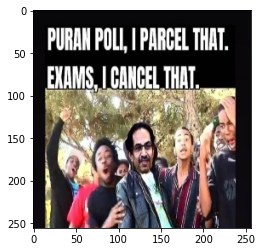

In [ ]:
images = np.load('drive/My Drive/Colab Notebooks/MVN_X.npy')
index = 85
tensors = np.transpose(images,(0,3,1,2))
tensors = torch.from_numpy(tensors).double()
with torch.no_grad():
  result = net(tensors[index].view(1,3,256,256).to(device))
  result = 1 if (result > 0.5) else 0
plt.imshow(images[index,:,:,::-1])
if(result):
  print('these are notes')
else:
  print('its a meme')